# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-08-05/data_eval_new/"
file_name = "int_norm_20150806_bgd_new_den.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

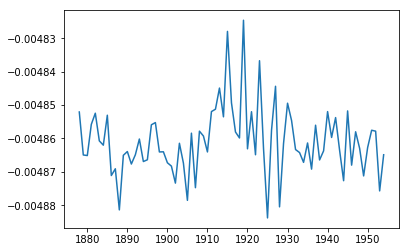

In [7]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

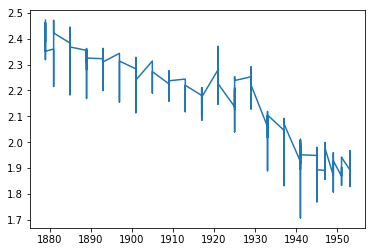

In [8]:
# Check Signals
column = "122"
sample = "SPEX 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [9]:
df_mean(signals[signals["118"] < 0.05])

,Filenumber,Sample,110,111,112,113,114,115,116,117,...,120_2,121_2,122_2,123_2,124_2,125_2,126_2,127_2,129_2,131_2
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-05 15:00:00,1878,blank sol,0.000083,0.000069,0.000200,0.000057,0.000175,0.000054,0.001839,0.000946,...,0.010878,0.000538,0.000598,0.000411,0.000828,0.000028,0.000123,0.034107,0.015156,0.012464
2015-08-05 15:23:00,1880,blank sol,0.000080,0.000075,0.000196,0.000061,0.000144,0.000048,0.001474,0.000752,...,0.010630,0.000522,0.000560,0.000419,0.000779,0.000022,0.000110,0.032913,0.015175,0.012475
2015-08-05 15:45:00,1882,blank sol,0.000082,0.000073,0.000215,0.000057,0.000192,0.000069,0.001828,0.000925,...,0.010675,0.000554,0.000560,0.000405,0.000758,0.000020,0.000102,0.033072,0.015186,0.012475
2015-08-05 16:08:00,1884,blank sol,0.000065,0.000053,0.000203,0.000063,0.000167,0.000040,0.001814,0.000928,...,0.010771,0.000506,0.000525,0.000384,0.000750,0.000025,0.000097,0.032406,0.014828,0.012217
2015-08-05 16:31:00,1886,blank sol,0.000079,0.000049,0.000184,0.000063,0.000163,0.000058,0.001577,0.000784,...,0.010931,0.000584,0.000588,0.000442,0.000789,0.000025,0.000102,0.031912,0.014959,0.012290
2015-08-05 16:53:00,1888,blank sol,0.000068,0.000052,0.000197,0.000063,0.000151,0.000035,0.001664,0.000836,...,0.010700,0.000475,0.000548,0.000378,0.000767,0.000023,0.000100,0.030703,0.014773,0.012169
2015-08-05 17:17:00,1890,blank sol,0.000084,0.000055,0.000174,0.000053,0.000162,0.000046,0.001338,0.000666,...,0.007050,0.000396,0.000352,0.000289,0.000558,0.000010,0.000091,0.029603,0.013647,0.010953
2015-08-05 17:40:00,1892,blank sol,0.000079,0.000050,0.000188,0.000055,0.000153,0.000044,0.001477,0.000748,...,0.009494,0.000466,0.000422,0.000355,0.000585,0.000016,0.000100,0.030369,0.014835,0.012223
2015-08-05 18:03:00,1894,blank sol,0.000063,0.000060,0.000151,0.000056,0.000123,0.000035,0.001097,0.000542,...,0.009187,0.000510,0.000384,0.000388,0.000556,0.000039,0.000113,0.029371,0.014432,0.011891


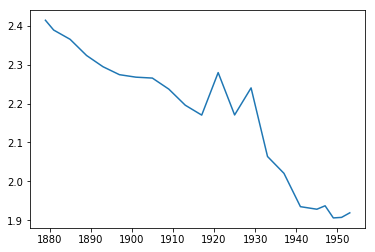

In [10]:
# Check Signals - mean
column = "122"
sample = "SPEX 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

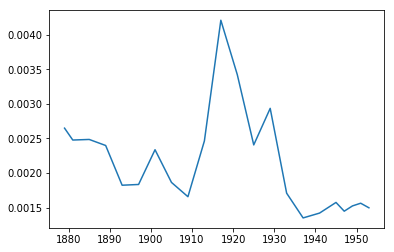

In [11]:
# Check background 
column = "118"
sample = "SPEX 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [12]:
background_mean = df_mean(background)

In [13]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [14]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [15]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_116_120"
interf_corr = "Te125_Xe129_corr"

In [16]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [19]:
column = "124/120"
sample = "SPEX 100ppb"

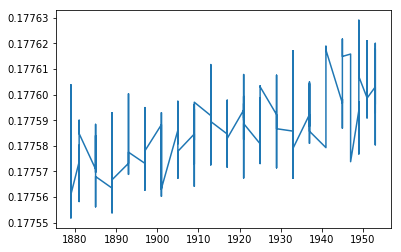

In [20]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [21]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


In [22]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2015-08-05 15:11:00,SPEX 100ppb,2,1,1879,0.029839,0.020205,0.010366,0.446,0.235281,0.742918,0.263442,0.142093,0.177569
2015-08-05 15:11:00,SPEX 100ppb,2,2,1879,0.029830,0.020202,0.010370,0.446,0.235276,0.742907,0.263451,0.142106,0.177589
2015-08-05 15:11:00,SPEX 100ppb,2,3,1879,0.029828,0.020197,0.010368,0.446,0.235293,0.742923,0.263445,0.142091,0.177566
2015-08-05 15:11:00,SPEX 100ppb,2,4,1879,0.029834,0.020203,0.010366,0.446,0.235283,0.742904,0.263436,0.142094,0.177575
2015-08-05 15:11:00,SPEX 100ppb,2,5,1879,0.029836,0.020206,0.010367,0.446,0.235291,0.742921,0.263445,0.142089,0.177563
2015-08-05 15:11:00,SPEX 100ppb,2,6,1879,0.029831,0.020200,0.010367,0.446,0.235285,0.742919,0.263450,0.142101,0.177579
2015-08-05 15:11:00,SPEX 100ppb,2,7,1879,0.029830,0.020201,0.010367,0.446,0.235280,0.742927,0.263438,0.142101,0.177583
2015-08-05 15:11:00,SPEX 100ppb,2,8,1879,0.029835,0.020200,0.010366,0.446,0.235290,0.742911,0.263436,0.142092,0.177572
2015-08-05 15:11:00,SPEX 100ppb,2,9,1879,0.029836,0.020205,0.010368,0.446,0.235296,0.742935,0.263440,0.142088,0.177552


In [23]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
1879        2015-08-05 15:11:00    0.177604
1891        2015-08-05 17:28:00    0.177555
1921        2015-08-05 23:08:00    0.177574
            2015-08-05 23:08:00    0.177567
1929        2015-08-06 00:40:00    0.177608
1943        2015-08-06 03:17:00    0.177576
Name: 124/120, dtype: float64

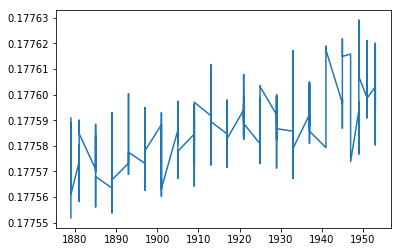

In [24]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [25]:
df[df["Sample"] == sample][column].std()

1.3729718739312775e-05

In [26]:
df_outlier_rej_int["Cd/Sn"] = signals[signals["Sample"] != "blank sol"]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[signals["Sample"] != "blank sol"]["Te/Sn"]

In [27]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

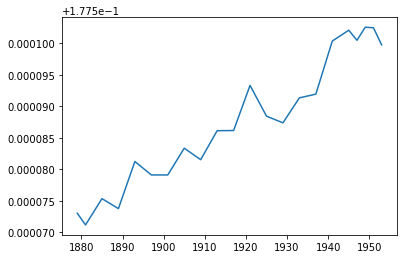

In [28]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [29]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2015-08-05 15:11:00,1879,SPEX 100ppb,0.029833,0.020202,0.010367,0.446,0.235286,0.742918,0.263442,0.142094,0.177573,0.000008,0.000027
2015-08-05 15:33:00,1881,SPEX 100ppb,0.029833,0.020200,0.010367,0.446,0.235289,0.742923,0.263439,0.142092,0.177571,0.000007,0.000027
2015-08-05 15:55:00,1883,NIST 100ppb,0.029832,0.020198,0.010360,0.446,0.235289,0.742916,0.263439,0.142094,0.177579,0.000007,0.000024
2015-08-05 16:18:00,1885,SPEX 100ppb,0.029830,0.020194,0.010367,0.446,0.235292,0.742924,0.263439,0.142095,0.177575,0.000010,0.000028
2015-08-05 16:41:00,1887,Cd-Sn-Std 1,0.029831,0.020197,0.010360,0.446,0.235292,0.742921,0.263439,0.142094,0.177574,0.000028,0.000026
2015-08-05 17:04:00,1889,SPEX 100ppb,0.029828,0.020194,0.010368,0.446,0.235289,0.742917,0.263437,0.142092,0.177574,0.000010,0.000023
2015-08-05 17:28:00,1891,SPEX1 Ag1x8_5,0.029830,0.020196,0.010360,0.446,0.235289,0.742922,0.263442,0.142095,0.177580,0.000007,0.000018
2015-08-05 17:50:00,1893,SPEX 100ppb,0.029833,0.020199,0.010368,0.446,0.235286,0.742915,0.263437,0.142097,0.177581,0.000005,0.000025
2015-08-05 18:13:00,1895,SPEX1 TRU_6 U,0.029829,0.020196,0.010359,0.446,0.235289,0.742915,0.263439,0.142095,0.177579,0.000013,0.000115


In [30]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [31]:
drop_sum = []

In [32]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

/Users/marf/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/marf/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marf/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [33]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [34]:
data_mean_int_sum

112/120                       114/120            \
                              mean           SD2 count      mean       SD2   
Sample                                                                       
BHVO-2 1_1(2)             0.029831           NaN     1  0.020195       NaN   
BHVO-2 1_2(2)             0.029834           NaN     1  0.020201       NaN   
BHVO-2 2_1                0.029833           NaN     1  0.020197       NaN   
Cd-Sn-Std 1               0.029831           NaN     1  0.020197       NaN   
NIST 100ppb               0.029832           NaN     1  0.020198       NaN   
SPEX 100ppb               0.029833  4.491668e-06    22  0.020199  0.000004   
SPEX 100ppb + 0.005ppb U  0.029834  6.789043e-07     2  0.020200  0.000003   
SPEX 100ppb + 0.05ppb U   0.029836  1.775662e-06     2  0.020200  0.000004   
SPEX1 1_1(1)              0.029833           NaN     1  0.020198       NaN   
SPEX1 Ag1x8_5             0.029830           NaN     1  0.020196       NaN   
SPEX1 TRU_6 U             0.029829           NaN     1  0.020196       NaN   
SPEX1-II 3_1              0.029834           NaN     1  0.020198       NaN   
SPEX1-II 4_1              0.029833           NaN     1  0.020198       NaN   
ZH09-05 10.3_1(1)         0.029831           NaN     1  0.020197       NaN   
ZH09-05 23.3_1(1)         0.029832           NaN     1  0.020201       NaN   

                                 115/120                     116/120  ...   \
                         count      mean           SD2 count    mean  ...    
Sample                                                                ...    
BHVO-2 1_1(2)                1  0.010361           NaN     1   0.446  ...    
BHVO-2 1_2(2)                1  0.010360           NaN     1   0.446  ...    
BHVO-2 2_1                   1  0.010359           NaN     1   0.446  ...    
Cd-Sn-Std 1                  1  0.010360           NaN     1   0.446  ...    
NIST 100ppb                  1  0.010360           NaN     1   0.446  ...    
SPEX 100ppb                 22  0.010368  1.583906e-06    22   0.446  ...    
SPEX 100ppb + 0.005ppb U     2  0.010367  8.457444e-07     2   0.446  ...    
SPEX 100ppb + 0.05ppb U      2  0.010368  1.495135e-06     2   0.446  ...    
SPEX1 1_1(1)                 1  0.010359           NaN     1   0.446  ...    
SPEX1 Ag1x8_5                1  0.010360           NaN     1   0.446  ...    
SPEX1 TRU_6 U                1  0.010359           NaN     1   0.446  ...    
SPEX1-II 3_1                 1  0.010359           NaN     1   0.446  ...    
SPEX1-II 4_1                 1  0.010360           NaN     1   0.446  ...    
ZH09-05 10.3_1(1)            1  0.010359           NaN     1   0.446  ...    
ZH09-05 23.3_1(1)            1  0.010359           NaN     1   0.446  ...    

                         122/120   124/120                     Cd/Sn  \
                           count      mean       SD2 count      mean   
Sample                                                                 
BHVO-2 1_1(2)                  1  0.177581       NaN     1  0.000012   
BHVO-2 1_2(2)                  1  0.177579       NaN     1  0.000023   
BHVO-2 2_1                     1  0.177582       NaN     1  0.000014   
Cd-Sn-Std 1                    1  0.177574       NaN     1  0.000028   
NIST 100ppb                    1  0.177579       NaN     1  0.000007   
SPEX 100ppb                   22  0.177588  0.000021    22  0.000007   
SPEX 100ppb + 0.005ppb U       2  0.177591  0.000003     2  0.000006   
SPEX 100ppb + 0.05ppb U        2  0.177597  0.000004     2  0.000005   
SPEX1 1_1(1)                   1  0.177590       NaN     1  0.000003   
SPEX1 Ag1x8_5                  1  0.177580       NaN     1  0.000007   
SPEX1 TRU_6 U                  1  0.177579       NaN     1  0.000013   
SPEX1-II 3_1                   1  0.177580       NaN     1  0.000008   
SPEX1-II 4_1                   1  0.177582       NaN     1  0.000009   
ZH09-05 10.3_1(1)              1  0.177585       NaN     1  0.000

In [35]:
date_list = []

epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX 100ppb", 1000)

In [36]:
epsilon_int_SPEX = epsilon_int_SPEX.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [37]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-08-05 15:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPEX 100ppb
2015-08-05 15:33:00,-5.313496,0.645000,0.809101,-0.142938,0.000000e+00,0.003184,0.029827,-0.042852,-0.190934,-0.169873,SPEX 100ppb
2015-08-05 15:55:00,0.000000,0.220374,0.274712,-7.063935,0.000000e+00,-0.051929,-0.096030,0.001065,0.049655,0.345316,NIST 100ppb
2015-08-05 16:18:00,0.000000,-0.373694,-1.296319,-0.803611,2.220446e-12,0.138072,0.050797,0.034313,0.215814,0.162311,SPEX 100ppb
2015-08-05 16:41:00,0.000000,0.588847,1.306755,-7.238825,0.000000e+00,0.079460,0.004635,0.049750,0.044146,-0.049388,Cd-Sn-Std 1
2015-08-05 17:04:00,0.000000,-1.063337,-1.241273,1.165757,-1.110223e-12,-0.020045,-0.024666,-0.042898,-0.279927,-0.255621,SPEX 100ppb
2015-08-05 17:28:00,0.000000,-0.058222,-0.116975,-7.760329,2.220446e-12,0.050257,0.081192,0.175549,0.002838,0.146082,SPEX1 Ag1x8_5
2015-08-05 17:50:00,0.000000,0.754285,1.444470,-0.573633,2.220446e-12,-0.100255,-0.054114,0.052854,0.249435,0.270985,SPEX 100ppb
2015-08-05 18:13:00,0.000000,-1.250301,-0.998782,-8.311223,0.000000e+00,0.075749,-0.024516,0.100396,-0.053283,-0.081790,SPEX1 TRU_6 U


In [38]:

date_list = []

epsilon_int_SPEX = epsilon_int_SPEX.drop(date_list)
delta_raw_SPEX = delta_raw_SPEX.drop(date_list)

In [39]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -5) & (df["Filenumber"] <= 5)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [40]:
epsilon_int_SPEX = epsilon_process(epsilon_int_SPEX)
delta_raw_SPEX = epsilon_process(delta_raw_SPEX)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-08-05 15:55:00,1883,0.220374,0.274712,-7.063935,0.000000e+00,-0.051929,-0.096030,0.001065,0.049655,0.345316,NIST 100ppb
2015-08-05 16:18:00,1885,-0.373694,-1.296319,-0.803611,2.220446e-12,0.138072,0.050797,0.034313,0.215814,0.162311,SPEX 100ppb
2015-08-05 16:41:00,1887,0.588847,1.306755,-7.238825,0.000000e+00,0.079460,0.004635,0.049750,0.044146,-0.049388,Cd-Sn-Std 1
2015-08-05 17:04:00,1889,-1.063337,-1.241273,1.165757,-1.110223e-12,-0.020045,-0.024666,-0.042898,-0.279927,-0.255621,SPEX 100ppb
2015-08-05 17:28:00,1891,-0.058222,-0.116975,-7.760329,2.220446e-12,0.050257,0.081192,0.175549,0.002838,0.146082,SPEX1 Ag1x8_5
2015-08-05 17:50:00,1893,0.754285,1.444470,-0.573633,2.220446e-12,-0.100255,-0.054114,0.052854,0.249435,0.270985,SPEX 100ppb
2015-08-05 18:13:00,1895,-1.250301,-0.998782,-8.311223,0.000000e+00,0.075749,-0.024516,0.100396,-0.053283,-0.081790,SPEX1 TRU_6 U
2015-08-05 18:36:00,1897,-0.189770,-0.120840,0.332321,0.000000e+00,0.021054,0.044301,-0.081403,-0.066253,-0.059830,SPEX 100ppb
2015-08-05 18:59:00,1899,0.285648,1.809563,-7.725997,0.000000e+00,-0.117157,-0.088566,-0.103451,-0.102374,-0.028536,BHVO-2 1_2(2)


In [42]:
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_SPEX_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_SPEX_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [43]:
epsilon_sum_all

112/120              114/120              115/120  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
BHVO-2 1_1(2)             -0.670    NaN     1  -2.161    NaN     1  -6.814   
BHVO-2 1_2(2)              0.286    NaN     1   1.810    NaN     1  -7.726   
BHVO-2 2_1                -0.021    NaN     1  -0.788    NaN     1  -6.874   
Cd-Sn-Std 1                0.589    NaN     1   1.307    NaN     1  -7.239   
NIST 100ppb                0.220    NaN     1   0.275    NaN     1  -7.064   
SPEX 100ppb               -0.073  1.563    18  -0.139  2.145    18   0.012   
SPEX 100ppb + 0.005ppb U  -0.168  0.390     2  -0.309  1.700     2   0.019   
SPEX 100ppb + 0.05ppb U    0.283  0.445     2   0.470  2.236     2   1.017   
SPEX1 1_1(1)              -0.109    NaN     1  -0.921    NaN     1  -6.539   
SPEX1 Ag1x8_5             -0.058    NaN     1  -0.117    NaN     1  -7.760   
SPEX1 TRU_6 U             -1.250    NaN     1  -0.999    NaN     1  -8.311   
SPEX1-II 3_1              -0.387    NaN     1  -1.384    NaN     1  -8.244   
SPEX1-II 4_1              -0.642    NaN     1  -1.581    NaN     1  -8.422   
ZH09-05 10.3_1(1)         -0.528    NaN     1  -0.228    NaN     1  -8.705   
ZH09-05 23.3_1(1)         -0.053    NaN     1   1.232    NaN     1  -8.077   

                                      116/120  ...  118/120 119/120         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
BHVO-2 1_1(2)               NaN     1     0.0  ...        1  -0.004    NaN   
BHVO-2 1_2(2)               NaN     1     0.0  ...        1  -0.103    NaN   
BHVO-2 2_1                  NaN     1     0.0  ...        1  -0.029    NaN   
Cd-Sn-Std 1                 NaN     1     0.0  ...        1   0.050    NaN   
NIST 100ppb                 NaN     1     0.0  ...        1   0.001    NaN   
SPEX 100ppb               1.494    18     0.0  ...       18  -0.001  0.095   
SPEX 100ppb + 0.005ppb U  0.589     2     0.0  ...        2   0.099  0.035   
SPEX 100ppb + 0.05ppb U   1.688     2     0.0  ...        2   0.852  0.184   
SPEX1 1_1(1)                NaN     1     0.0  ...        1   0.149    NaN   
SPEX1 Ag1x8_5               NaN     1     0.0  ...        1   0.176    NaN   
SPEX1 TRU_6 U               NaN     1     0.0  ...        1   0.100    NaN   
SPEX1-II 3_1                NaN     1    -0.0  ...        1   0.024    NaN   
SPEX1-II 4_1                NaN     1     0.0  ...        1  -0.145    NaN   
ZH09-05 10.3_1(1)           NaN     1     0.0  ...        1  -0.103    NaN   
ZH09-05 23.3_1(1)           NaN     1     0.0  ...        1   0.007    NaN   

                               122/120              124/120               
                         count    mean    SD2 count    mean    SD2 count  
Sample                                                                    
BHVO-2 1_1(2)                1  -0.340    NaN     1  -0.481    NaN     1  
BHVO-2 1_2(2)                1  -0.102    NaN     1  -0.029    NaN     1  
BHVO-2 2_1                   1  -0.170    NaN     1  -0.116    NaN     1  
Cd-Sn-Std 1                  1   0.044    NaN     1  -0.049    NaN     1  
NIST 100ppb                  1   0.050    NaN     1   0.345    NaN     1  
SPEX 100ppb                 18   0.003  0.268    18   0.006  0.364    18  
SPEX 100ppb + 0.005ppb U     2   0.035  0.322     2   0.051  0.030     2  
SPEX 100ppb + 0.05ppb U      2  -0.018  0.062     2  -0.096  0.158     2  
SPEX1 1_1(1)                 1   0.156    NaN     1   0.216    NaN     1  
SPEX1 Ag1x8_5                1   0.003    NaN     1   0.146    NaN     1  
SPEX1 TRU_6 U                1  -0.053    NaN     1  -0.082    NaN     1  
SPEX1-II 3_1                 1  -0.245    NaN     1  -0.462    NaN     1  
SPEX1-II 4_1                 1  -0.178    NaN     1  -0.474    NaN     1  
ZH09-05 10.3_1(

In [280]:
delta_raw_sum_all

112/118              114/118              115/118  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
BHVO-2 1_1(2)              0.253    NaN     1   0.004    NaN     1  -0.516   
BHVO-2 1_2(2)              0.215    NaN     1   0.307    NaN     1  -0.676   
BHVO-2 2_1                -0.287    NaN     1  -0.267    NaN     1  -0.828   
Cd-Sn-Std 1                0.200    NaN     1   0.223    NaN     1  -0.663   
NIST 100ppb                0.403    NaN     1   0.295    NaN     1  -0.515   
SPEX 100ppb               -0.013  0.484    20  -0.017  0.323    20  -0.005   
SPEX 100ppb + 0.005ppb U  -0.119  0.025     2  -0.106  0.143     2  -0.062   
SPEX 100ppb + 0.05ppb U    0.007  0.226     2   0.002  0.359     2   0.062   
SPEX1 1_1(1)              -0.183    NaN     1  -0.193    NaN     1  -0.739   
SPEX1 Ag1x8_5              0.122    NaN     1   0.064    NaN     1  -0.721   
SPEX1 TRU_6 U             -0.308    NaN     1  -0.226    NaN     1  -0.925   
SPEX1-II 3_1               0.878    NaN     1   0.469    NaN     1  -0.370   
SPEX1-II 4_1              -0.249    NaN     1  -0.317    NaN     1  -0.960   
ZH09-05 10.3_1(1)         -0.346    NaN     1  -0.257    NaN     1  -1.014   
ZH09-05 23.3_1(1)         -0.927    NaN     1  -0.486    NaN     1  -1.262   

                                      116/118  ...  119/118 120/118         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
BHVO-2 1_1(2)               NaN     1   0.112  ...        1  -0.098    NaN   
BHVO-2 1_2(2)               NaN     1   0.067  ...        1  -0.049    NaN   
BHVO-2 2_1                  NaN     1  -0.093  ...        1   0.093    NaN   
Cd-Sn-Std 1                 NaN     1   0.046  ...        1  -0.059    NaN   
NIST 100ppb                 NaN     1   0.139  ...        1  -0.114    NaN   
SPEX 100ppb               0.310    20  -0.003  ...       20   0.003  0.165   
SPEX 100ppb + 0.005ppb U  0.055     2  -0.040  ...        2   0.021  0.016   
SPEX 100ppb + 0.05ppb U   0.085     2  -0.022  ...        2   0.009  0.057   
SPEX1 1_1(1)                NaN     1  -0.060  ...        1   0.039    NaN   
SPEX1 Ag1x8_5               NaN     1   0.039  ...        1  -0.050    NaN   
SPEX1 TRU_6 U               NaN     1  -0.061  ...        1   0.065    NaN   
SPEX1-II 3_1                NaN     1   0.304  ...        1  -0.280    NaN   
SPEX1-II 4_1                NaN     1  -0.077  ...        1   0.062    NaN   
ZH09-05 10.3_1(1)           NaN     1  -0.095  ...        1   0.096    NaN   
ZH09-05 23.3_1(1)           NaN     1  -0.309  ...        1   0.304    NaN   

                               122/118              124/118               
                         count    mean    SD2 count    mean    SD2 count  
Sample                                                                    
BHVO-2 1_1(2)                1  -0.222    NaN     1  -0.325    NaN     1  
BHVO-2 1_2(2)                1  -0.112    NaN     1  -0.155    NaN     1  
BHVO-2 2_1                   1   0.166    NaN     1   0.240    NaN     1  
Cd-Sn-Std 1                  1  -0.117    NaN     1  -0.166    NaN     1  
NIST 100ppb                  1  -0.239    NaN     1  -0.358    NaN     1  
SPEX 100ppb                 20   0.005  0.322    20   0.008  0.495    20  
SPEX 100ppb + 0.005ppb U     2   0.063  0.057     2   0.089  0.036     2  
SPEX 100ppb + 0.05ppb U      2   0.029  0.104     2   0.028  0.257     2  
SPEX1 1_1(1)                 1   0.103    NaN     1   0.149    NaN     1  
SPEX1 Ag1x8_5                1  -0.097    NaN     1  -0.116    NaN     1  
SPEX1 TRU_6 U                1   0.130    NaN     1   0.179    NaN     1  
SPEX1-II 3_1                 1  -0.588    NaN     1  -0.898    NaN     1  
SPEX1-II 4_1                 1   0.121    NaN     1   0.127    NaN     1  
ZH09-05 10.3_1(

In [246]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [258]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [250]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [251]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [44]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [45]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_SPEX.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_SPEX.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [46]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [284]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')